<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/07-trees/DecisionTrees_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 (3 points)

Generate a toy dataset for the "XOR" problem:

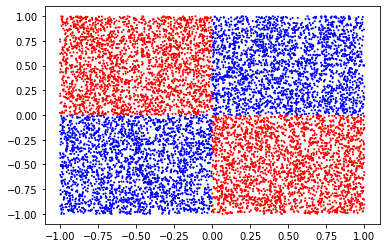

i.e. where the two features are distributed **uniformly** in $[-1, 1]$, and the target is $y = (x_0 >= 0) \text{ XOR } (x_1 >= 0)$.

Let the total number of points in the dataset be $N=10000$.

Fit a `sklearn.tree.DecisionTreeClassifier` on this data. Find a minimal `max_depth` value that results in train accuracy $>0.99$.

For each value of `max_depth` from 1 to the value found above, plot the data with the decision boundary for the obtained model. (*Hint: use `s=1` argument to `plt.scatter` to be able to see anything behind the data points.*)

For the model with train accuracy $>0.99$ use `sklearn.tree.plot_tree` to observe the tree structure.

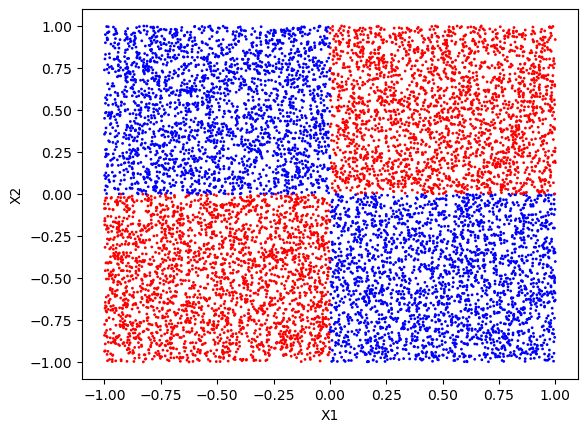

In [81]:
import numpy as np 
import matplotlib.pyplot as plt 

# just to have same result each time
np.random.seed(45)

X = np.random.uniform(low=-1, high=1, size=(10000,2))
y = np.bitwise_xor(np.sign(X[:,1]).astype(int),np.sign(X[:,0]).astype(int))

plt.scatter(X[:,0],X[:,1], c=y, s=1, cmap='bwr')
plt.xlabel('X1')
plt.ylabel('X2')

plt.show()

In [82]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

model = DecisionTreeClassifier(max_depth=3)

# print(X.shape)
model.fit(X,y)

y_pred = model.predict(X)

print(accuracy_score(y, y_pred))


0.9958


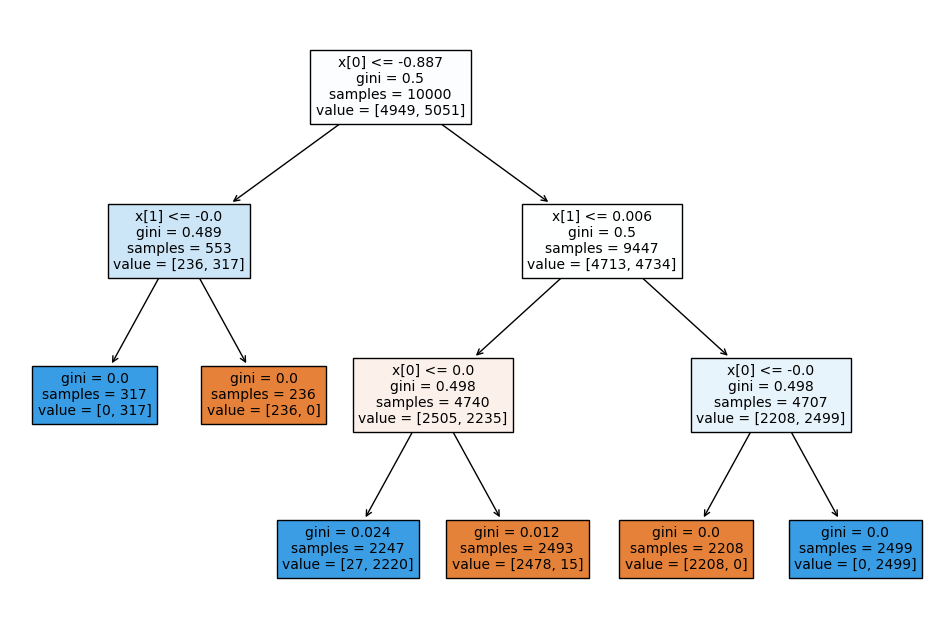

In [83]:
# printing tree 
from sklearn.tree import plot_tree

plt.figure(figsize=(12, 8), dpi=100)
plot_tree(model, fontsize=10, filled=True);

in native level it is reasonable to make the root first division into <> 0, but because of the entropy rule of decision tree leafs division, we get extra thresholds to make desired answer.

So, depth=3 allow us to solve XOR problem with accuracy > .99
Let's do some plots:

In [84]:
# first, we take code from classwork and modify it a bit
def plot_decision_surface(
                  clf, X, y, ax,
                  nx=200, ny=100,
                  cmap='bwr',
                  alpha=0.6,
                  
        ):
    """
    Plot the decision boundary of clf on X and y, visualize training points
    """
    
    # Define the grid
    x_top_left = X.min(axis=0) - 1
    x_bottom_right = X.max(axis=0) + 1
    grid_x0, grid_x1 = np.meshgrid(
         np.linspace(x_top_left[0], x_bottom_right[0], ny),
         np.linspace(x_top_left[1], x_bottom_right[1], nx)
      )
    
    # Calculate predictions on the grid
    y_pred_grid = clf.predict(
                        np.stack(
                              [
                                grid_x0.ravel(),
                                grid_x1.ravel()
                              ],
                              axis=1
                            )
                      ).reshape(grid_x1.shape)
    
    # Find optimal contour levels and make a filled
    # contour plot of predictions
    labels = np.sort(np.unique(y))
    labels = np.concatenate([[labels[0] - 1],
                             labels,
                             [labels[-1] + 1]])
    medians = (labels[1:] + labels[:-1]) / 2
    ax.contourf(grid_x0, grid_x1, y_pred_grid, cmap=cmap, alpha=alpha,
                 levels=medians)
    
    # Scatter data points on top of the plot,
    # with different styles for correct and wrong
    # predictions
    y_pred = clf.predict(X)
    ax.scatter(*X[y_pred==y].T, c=y[y_pred==y],
                marker='o', cmap=cmap, s=10, label='correct')
    ax.scatter(*X[y_pred!=y].T, c=y[y_pred!=y],
                marker='x', cmap=cmap, s=50, label='errors')

    # Dummy plot call to print the accuracy in the legend.
    ax.plot([], [], ' ',
             label='Accuracy = {:.3f}'.format(accuracy_score(y, y_pred)))
    
    ax.legend(loc='best')

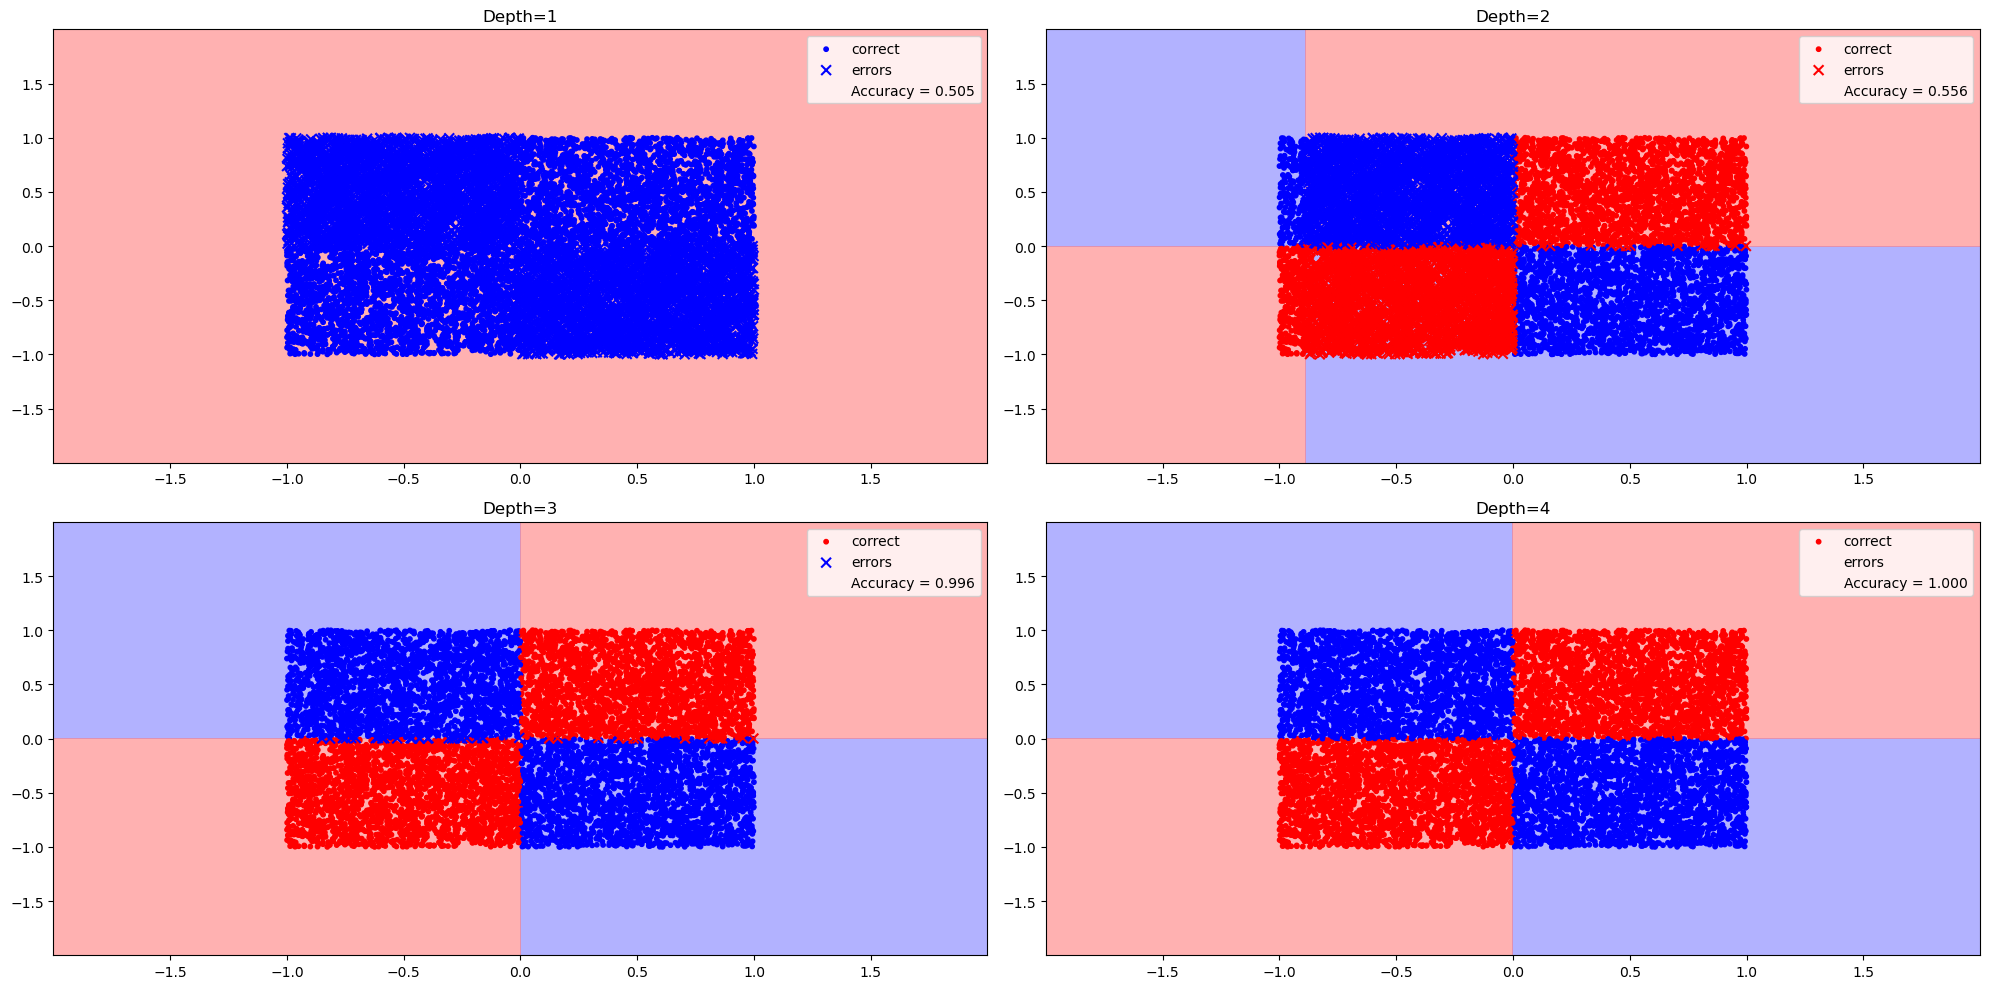

In [85]:
depths = range(1,5) #we include 4 because 4 gives us accuracy = 1 
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,10))
axs = [ax1, ax2, ax3, ax4]

for d, ax in zip(depths, axs):
    model = DecisionTreeClassifier(max_depth=d)
    model.fit(X,y)
    plot_decision_surface(model, X, y, ax)
    ax.set_title(f'Depth={d}')
    plt.tight_layout()

# Task 2 (3 points)

Consider the following dataset:

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
print(data.DESCR)

X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target_names[data.target]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

print(X_train.iloc[:5])
print(y_train[:5])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

Build a `sklearn.tree.DecisionTreeClassifier` to maximize the test ROC AUC score.

When predicting cancer, it's much more dangerous to have a false negative prediction rather than false positive. Try to find the best tree (in terms of test ROC AUC) where the labels are re-weighted with the `class_weight={'malignant' : 2., 'benign' : 1.}` argument provided to the `DecisionTreeClassifier` constructor.

Plot test ROC curves for the two best models you found on the same plot.

If it is more risky to have false negative result, it's  better to maximaze recall of the model

In [87]:
target = {'malignant' : 1, 'benign' : 0}
y_test = np.array([target[val] for val in y_test])
y_train = np.array([target[val] for val in y_train])
y = np.array([target[val] for val in y])

I'm not going to deeply analyze each feature to find best solution of DT, i'm going to use gridsearch to tune tree on basic data to find the best models 

In [117]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV 

class_weight = {1 : 2.,
                0: 1.}

clf = DecisionTreeClassifier(class_weight=class_weight, random_state=45)
cv = 4 
params = {
    'max_depth' : [4,6,8,10,12],
    'min_samples_leaf' : [1,2,3,4],
    'max_features' : ['auto', 'sqrt', 'log2', 10]
}
model = GridSearchCV(clf, params, cv=cv, scoring='roc_auc', verbose=True) 
model.fit(X,y)

params = model.best_params_

model.best_score_



Fitting 4 folds for each of 80 candidates, totalling 320 fits


0.9635019904364828

In [121]:
clf = DecisionTreeClassifier(**params, class_weight=class_weight, random_state=45)
clf.fit(X_train, y_train)

# create model with max_depth i bit different than in best model
clf1 = DecisionTreeClassifier(max_depth= 6, max_features='auto', min_samples_leaf=3, random_state=45)
clf1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, max_features='auto', min_samples_leaf=3,
                       random_state=45)

Let's make baseline prediction

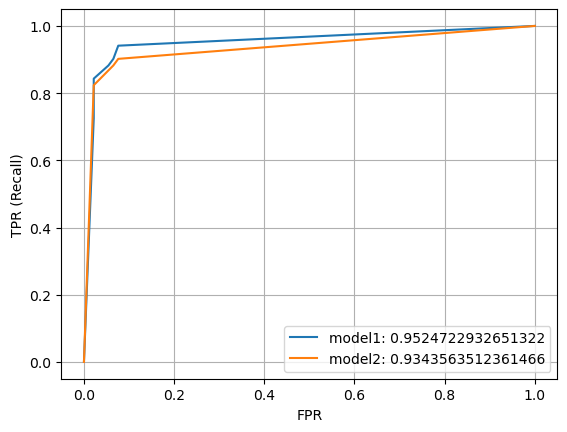

In [123]:
import warnings 
warnings.filterwarnings("ignore")


y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

y_pred_proba1 = clf1.predict_proba(X_test)[::,1]
fpr1, tpr1, _ = metrics.roc_curve(y_test,  y_pred_proba1)
auc1 = metrics.roc_auc_score(y_test, y_pred_proba1)

plt.plot(fpr,tpr,label="model1: "+str(auc))
plt.plot(fpr1,tpr1,label="model2: "+str(auc1))
plt.legend()
plt.ylabel('TPR (Recall)')
plt.xlabel('FPR')
plt.grid()
plt.show()

As a result, we received two models scores, they are both good, but first one shows better score. we have 0.95 Recall on only ~0.12 False positive rate, i guess, it is quite good result. 
Our model catches ~95% data from all actual positive sampes in trade with only 12% of false positive predictions

In [149]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]


def fpr_m(y_true, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    false_positive_rate = fp / (fp + tn) if (fp + tn) != 0 else 0
    return false_positive_rate

for thresh in thresholds:
    pred = (y_pred_proba >= thresh).astype(int)
    recall = metrics.recall_score(y_test, pred)
    fpr = fpr_m(y_test, pred)
    print(f"Threshold: {thresh}, Recall: {recall}, FPR: {fpr}")

Threshold: 0.1, Recall: 0.9411764705882353, FPR: 0.07608695652173914
Threshold: 0.2, Recall: 0.9411764705882353, FPR: 0.07608695652173914
Threshold: 0.3, Recall: 0.9411764705882353, FPR: 0.07608695652173914
Threshold: 0.4, Recall: 0.9411764705882353, FPR: 0.07608695652173914
Threshold: 0.5, Recall: 0.9411764705882353, FPR: 0.07608695652173914
Threshold: 0.6, Recall: 0.9019607843137255, FPR: 0.06521739130434782
Threshold: 0.7, Recall: 0.8823529411764706, FPR: 0.05434782608695652
Threshold: 0.8, Recall: 0.8823529411764706, FPR: 0.05434782608695652


In [153]:
series = pd.Series(y)
series.value_counts()

0    357
1    212
Name: count, dtype: int64

I guess, .5 thresh in this case is good because it allows to have the same TPR and FPR on data without setting extra values for thresh